# PGExplainer

PGExplainer is an explainer model for graph neural networks. It achieves up to 24.7% relative improvement in AUC on explaining graph classification over the leading baseline. In fact, w.r.t. GNNExplainer, that explains only why a GNN model makes the prediction for a single instance, PGExplainer uses a deep neural network model to generalize the prediction of a GNN explanation over a set of instances.

This is done by maximizing the mutual information between the GNN predictions on the entire graph and the underlying structure (the predicted subgraph).
That is, if a graph $G_0$ can be splitted in two different subgraphs: $G_s$ and $\Delta G$, s.t. $G_s$ only contains the edges that are relevant for GNN's prediction $Y_0$, then the mutual information formula is the followoing:
$$ \max_{G_s} MI(Y_0; G_s) = H(Y_0) - H(Y_0 | G = G_s) $$

After some approximation and a reparametrization trick, the formula to be optimized is the following:
$$ \min_{\Omega} - {1 \over K} \sum_{k=1}^K \sum_{c=1}^C P_{\Phi}(Y = c | G = G_0) log P_{\Phi} (Y = c | G = \hat{G}_s^{(k)}) $$

Where $\Phi$ denotes the parameters in the trained GNN, $K$ is the total number of sampled graph, $C$ is
the number of labels, and $\hat{G}_s^{(k)}$ is the $k$-th graph sampled via the $MLP_{\Omega}$ model trained on the GNN model embeddings.

The following figure (taken from the authors' paper) shows the PGExplainer model architecture:

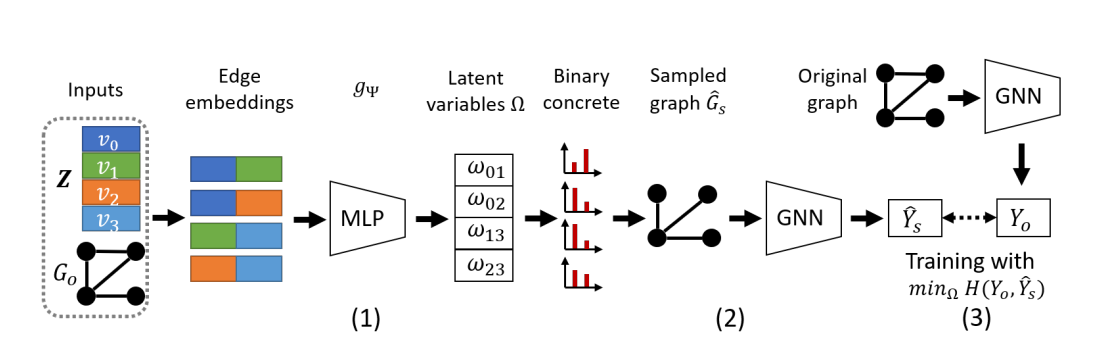

The authors trained two GNN models (one for node and one for graph classification) on 5 syntetic datasets and a real one. The results of their work are shown in the following figure:

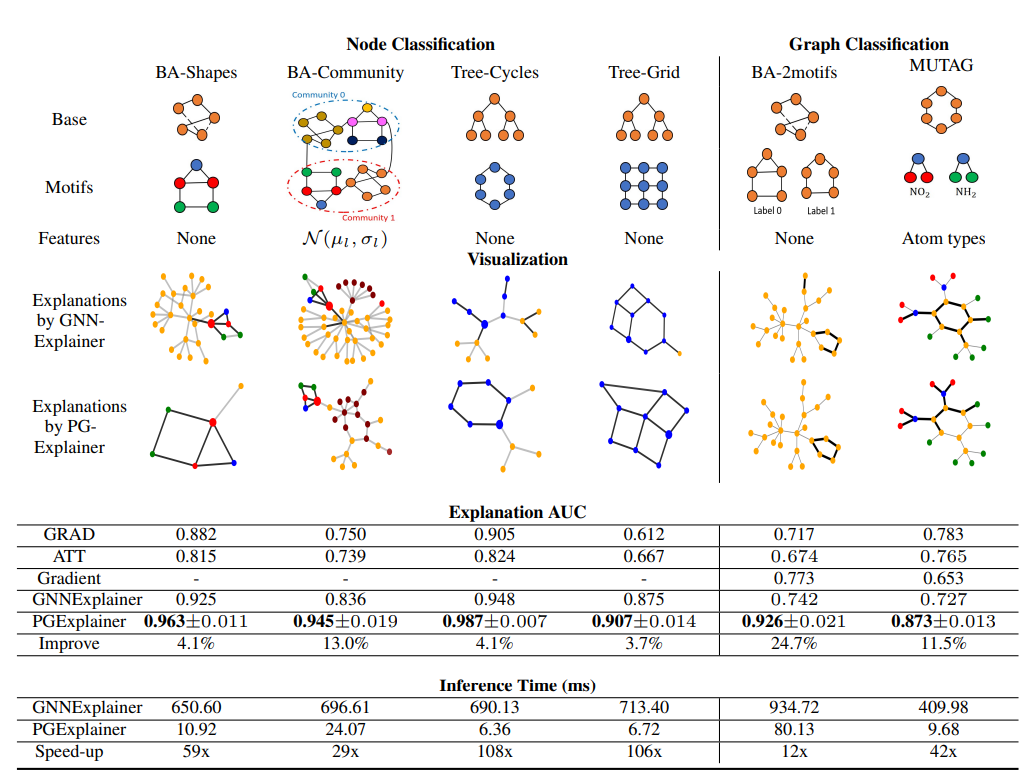

## Implementation

Following their paper, in this notebook, two GNN models are trained on two datasets (BA-Shapes and a custom BA2-Motifs) and then the PGExplainer model is trained on the trained GNN models. Similar results where obtained with regards of the auc score for the node classification task. Howevere, the graph classification auc score was not obtained as expected, even if the PGExplainer model converged correctly during the training process. So this is probably related to a computation error of the metric.

The project was implemented using PyTorch, more specifically, PyTorchLighting for model definitions and training, PyTorchGeometric for its Graph utilities and neural networks layers.

In order to run the code, you need to have installed Python (version 3.8) and then install all the required packages via the requirements.txt file in this repository.

## Imports

In [90]:
import os
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy

import torch_geometric as pygeom
import torch_geometric.transforms as T
from torch_geometric.datasets import ExplainerDataset
from torch_geometric.nn import global_max_pool, global_mean_pool
from torch_geometric.loader import DataLoader, NeighborLoader, RandomNodeLoader
from torch_geometric.utils import k_hop_subgraph
from torch_geometric.explain.metric import groundtruth_metrics
from torch_geometric.datasets.graph_generator import BAGraph
from torch_geometric.datasets.motif_generator import HouseMotif
from torch_geometric.datasets.motif_generator import CycleMotif

import lightning.pytorch as pl

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import networkx as nx
import matplotlib.colors as mcolors
from typing import Optional, Union, Any

In [91]:
pl.seed_everything(42)

Global seed set to 42


42

## Datasets

### Node classification: BA-Shapes

A single graph generated using the Barabasi-Albert model. The graph contains a certain number of motifs (shapes) that are connected to each other. The task is to classify the nodes of the graph as part of a specific shape.

In [92]:
trans = pygeom.transforms.Compose([T.Constant(), ])

node_dataset = ExplainerDataset(
    graph_generator=pygeom.datasets.graph_generator.BAGraph(num_nodes=300, num_edges=5),
    motif_generator='house',
    num_motifs=80,
    transform=trans,
)

In [93]:
node_dataset

ExplainerDataset(1, graph_generator=BAGraph(num_nodes=300, num_edges=5), motif_generator=HouseMotif(), num_motifs=80)

In [94]:
g = node_dataset[0]

In [95]:
g

Explanation(edge_index=[2, 3958], y=[700], edge_mask=[3958], node_mask=[700], x=[700, 1])

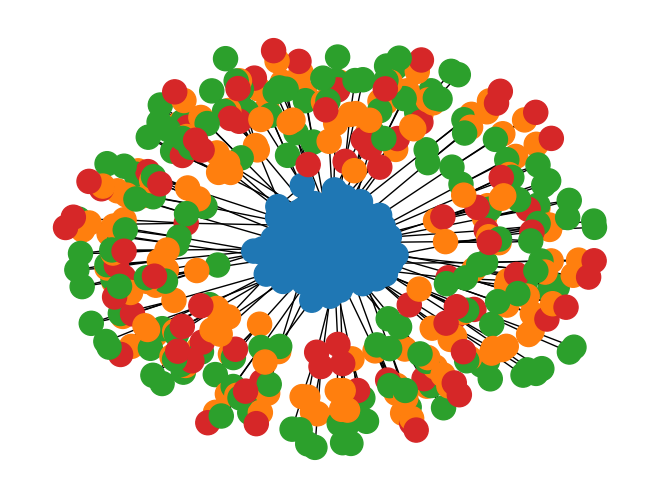

In [96]:
colors = list(mcolors.TABLEAU_COLORS)
nx.draw(pygeom.utils.to_networkx(g, to_undirected=True),
        node_color=[colors[i % len(colors)] for i in g.y])

In [97]:
train_idx, val_test_idx =  train_test_split(torch.arange(g.num_nodes), stratify=g.y, train_size=0.8)
val_idx, test_idx = train_test_split(val_test_idx, stratify=g.y[val_test_idx], train_size=0.5)

In [98]:
data_loader = DataLoader(node_dataset, batch_size=1, shuffle=False)
node_dataloader = {"train": data_loader,
                   "val": data_loader,
                   "test": data_loader}
node_idx = {"train": train_idx,
            "val": val_idx,
            "test": test_idx}

### Graph classification: BA2Motifs

A dataset of graphs generated using the Barabasi-Albert model. Two different types of motifs (houses and cycles) are generated and each graph contains only one of them. The task is to classify the graphs as belonging to one of the two types.

In [137]:
graph_dataset = []
trans = pygeom.transforms.Compose([T.OneHotDegree(20),])

dataset1 = ExplainerDataset(
    graph_generator=BAGraph(num_nodes=25, num_edges=1),
    motif_generator=HouseMotif(),
    num_motifs=1,
    num_graphs=500,
    transform=trans
)

for i in range(len(dataset1)):
    d = dataset1[i].clone()
    d.y = torch.tensor([1])
    graph_dataset.append(d)

dataset2 = ExplainerDataset(
    graph_generator=BAGraph(num_nodes=25, num_edges=1),
    motif_generator=CycleMotif(5),
    num_motifs=1,
    num_graphs=500,
    transform=trans
)

for i in range(len(dataset2)):
    d = dataset2[i].clone()
    d.y = torch.tensor([0])
    graph_dataset.append(d)


In [138]:
graph_dataset[0]

Explanation(edge_index=[2, 58], y=[1], edge_mask=[58], node_mask=[30], x=[30, 21])

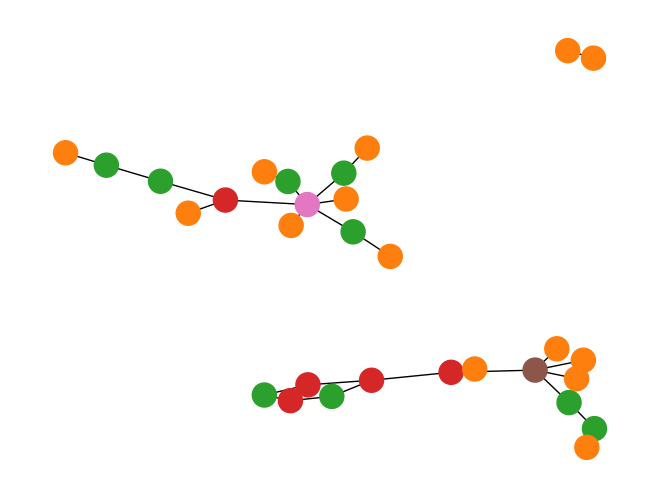

In [264]:
colors = list(mcolors.TABLEAU_COLORS)
nx.draw(pygeom.utils.to_networkx(graph_dataset[0], to_undirected=True),
        node_color=[colors[i % len(colors)] for i in graph_dataset[0].x.argmax(dim=-1)])

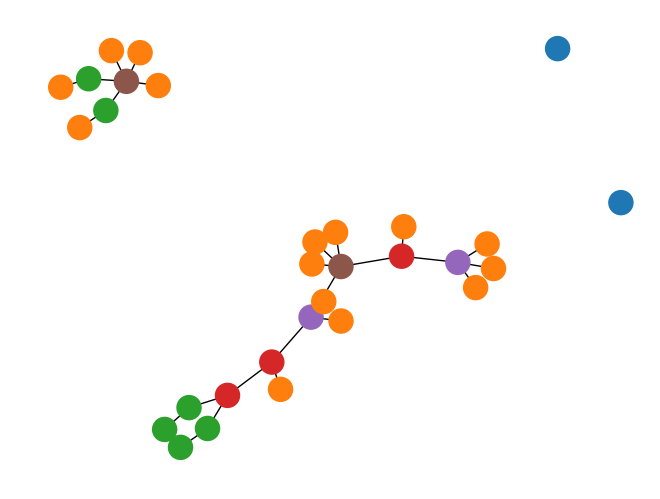

In [265]:
colors = list(mcolors.TABLEAU_COLORS)
nx.draw(pygeom.utils.to_networkx(graph_dataset[500], to_undirected=True),
        node_color=[colors[i % len(colors)] for i in graph_dataset[500].x.argmax(dim=-1)])

In [139]:
train_idx, val_test_idx =  train_test_split(torch.arange(len(graph_dataset)), stratify=torch.tensor([g.y for g in graph_dataset]), train_size=0.8)
val_idx, test_idx = train_test_split(val_test_idx, stratify=torch.tensor([g.y for i, g in enumerate(graph_dataset) if i in val_test_idx]), train_size=0.5)

In [141]:
train_dataset = [g for i, g in enumerate(graph_dataset) if i in train_idx]
val_dataset = [g for i, g in enumerate(graph_dataset) if i in val_idx]
test_dataset = [g for i, g in enumerate(graph_dataset) if i in test_idx]
print(len(train_dataset), len(val_dataset), len(test_dataset))

800 100 100


In [142]:
batch_size = 8
graph_dataloader = {"train": DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
                    "val": DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
                    "test": DataLoader(test_dataset, batch_size=batch_size, shuffle=False)}

## GNN models

### Node Classification

In [143]:
class NodeGNN(pl.LightningModule):
    """
        A simple 3-layered GNN for node classification.
    """
    def __init__(self, idcs, num_features, num_classes):
        super().__init__()
        self.gc1 = pygeom.nn.GCNConv(num_features, 20)
        self.gc2 = pygeom.nn.GCNConv(20, 20)
        self.gc3 = pygeom.nn.GCNConv(20, 20)
        self.dense = torch.nn.Linear(20, num_classes)
        self.train_idx = idcs["train"]
        self.val_idx = idcs["val"]

    def forward(self, data, edge_weights=None):
        out1 = F.relu(self.gc1(data.x, data.edge_index, edge_weights))
        out2 = F.relu(self.gc2(out1, data.edge_index, edge_weights))
        out3 = F.relu(self.gc3(out2, data.edge_index, edge_weights))
        embedding = out3
        return self.dense(out3), embedding


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

    def training_step(self, data, _):
        y_pred, _ = self(data)
        loss = F.cross_entropy(y_pred[self.train_idx], data.y[self.train_idx])
        self.log('train_loss', loss, prog_bar=True, batch_size=1)
        return loss

    def validation_step(self, data, _):
        y_hat, _ = self(data)
        self.log('val_accuracy', accuracy(y_hat[self.val_idx].argmax(dim=1), data.y[self.val_idx], task='multiclass', num_classes=4),
            prog_bar=True, batch_size=1)
        self.log('val_loss', F.cross_entropy(y_hat[self.val_idx], data.y[self.val_idx]),
            prog_bar=True, batch_size=1)
        
    def test_step(self, data, _):
        y_hat, _ = self(data)
        self.log('test_accuracy', accuracy(y_hat.argmax(dim=1), data.y, task='multiclass', num_classes=4),
            prog_bar=True, batch_size=1)
        self.log('test_loss', F.cross_entropy(y_hat, data.y),
            prog_bar=True, batch_size=1)

In [144]:
node_gnn = NodeGNN(node_idx, g.x.shape[1], g.y.max().item()+1)

In [145]:
node_gnn(g)

(tensor([[ 0.0540, -0.2805, -0.2973,  0.0563],
         [ 0.0702, -0.3087, -0.3144,  0.0832],
         [ 0.0221, -0.2252, -0.2636,  0.0033],
         ...,
         [-0.0356, -0.1249, -0.2026, -0.0925],
         [-0.0343, -0.1272, -0.2040, -0.0903],
         [-0.0368, -0.1228, -0.2013, -0.0945]], grad_fn=<AddmmBackward0>),
 tensor([[0.2576, 0.0000, 0.0000,  ..., 0.0000, 0.2508, 0.0000],
         [0.2860, 0.0000, 0.0000,  ..., 0.0000, 0.2785, 0.0000],
         [0.2016, 0.0000, 0.0000,  ..., 0.0000, 0.1963, 0.0000],
         ...,
         [0.1004, 0.0000, 0.0000,  ..., 0.0000, 0.0978, 0.0000],
         [0.1027, 0.0000, 0.0000,  ..., 0.0000, 0.1000, 0.0000],
         [0.0982, 0.0000, 0.0000,  ..., 0.0000, 0.0956, 0.0000]],
        grad_fn=<ReluBackward0>))

In [146]:
es_callback = pl.callbacks.EarlyStopping('val_loss', patience=5, mode='min')

In [147]:
trainer = pl.Trainer(max_epochs=2000, callbacks=[es_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [148]:
if os.path.isfile("checkpoints/BA-Shapes/node_gnn.ckpt"):
    trainer.fit(node_gnn, node_dataloader['train'], node_dataloader['val'], ckpt_path="checkpoints/BA-Shapes/node_gnn.ckpt")
else:
    trainer.fit(node_gnn, node_dataloader['train'], node_dataloader['val'])

Restoring states from the checkpoint path at checkpoints/BA-Shapes/node_gnn.ckpt
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from '/home/ninjak/Documenti/uni/neural_networks/neural-networks-exam/lightning_logs/version_0/checkpoints' to '/home/ninjak/Documenti/uni/neural_networks/lightning_logs/version_70/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | gc1   | GCNConv | 40    
1 | gc2   | GCNConv | 420   
2 | gc3   | GCNConv | 420   
3 | dense | Linear  | 84    
----------------------------------
964       Trainable params
0         Non-trainable params
964       Total params
0.004     Total estimated model params si

/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of trainin

In [149]:
trainer.test(node_gnn, node_dataloader['test'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 85.77it/s] 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9900000095367432     │
│         test_loss         │    0.04886212944984436    │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.9900000095367432, 'test_loss': 0.04886212944984436}]

<Axes: xlabel='epoch'>

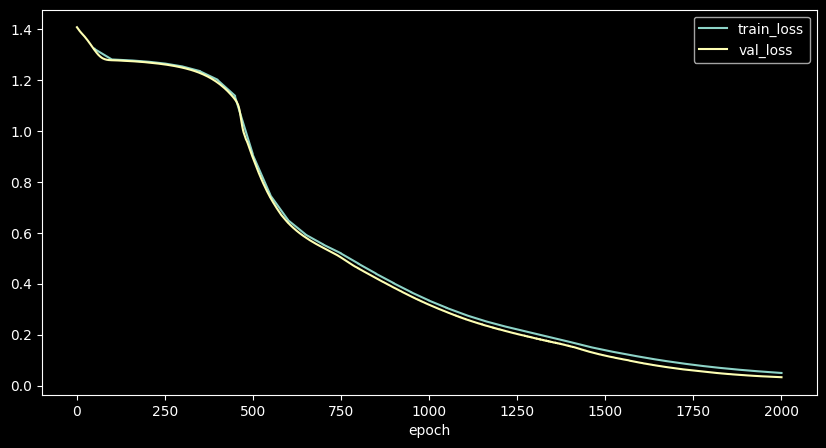

In [150]:
df = pd.read_csv('checkpoints/BA-Shapes/metrics_gnn.csv')
df.interpolate('linear').plot(x='epoch', y=['train_loss', 'val_loss'], figsize=(10, 5))

### Graph Classification

In [160]:
class GraphGNN(pl.LightningModule):
    """
        A simple 3-layered GNN for graph classification.
    """
    def __init__(self, batch_size, num_features, num_classes, lr=1e-3):
        super().__init__()
        self.gc1 = pygeom.nn.GCNConv(num_features, 20)
        self.gc2 = pygeom.nn.GCNConv(20, 20)
        self.gc3 = pygeom.nn.GCNConv(20, 20)
        self.dense = torch.nn.Linear(20, num_classes)
        self.batch_size = batch_size
        self.lr = lr

    def forward(self, batch, edge_weights=None):
        out1 = F.relu(self.gc1(batch.x, batch.edge_index, edge_weights))
        out2 = F.relu(self.gc2(out1, batch.edge_index, edge_weights))
        out3 = F.relu(self.gc3(out2, batch.edge_index, edge_weights))
        embedding = out3
        out = global_max_pool(out3, batch.batch)
        return self.dense(out), embedding


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

    def training_step(self, batch, _):
        y_pred, _ = self(batch)
        loss = F.binary_cross_entropy_with_logits(y_pred, batch.y.unsqueeze(1).float())
        self.log('train_loss', loss, prog_bar=True, batch_size=self.batch_size)
        return loss

    def validation_step(self, batch, _):
        y_hat, _ = self(batch)
        self.log('val_accuracy', accuracy(y_hat, batch.y.unsqueeze(1).float(), task='binary'),
                 prog_bar=True, batch_size=self.batch_size, on_step=False, on_epoch=True)
        self.log('val_loss', F.binary_cross_entropy_with_logits(y_hat, batch.y.unsqueeze(1).float()),
                 prog_bar=True, batch_size=self.batch_size, on_step=False, on_epoch=True)
        
    def test_step(self, batch, _):
        y_hat, _ = self(batch)
        self.log('test_accuracy', accuracy(y_hat, batch.y.unsqueeze(1).float(), task='binary'),
            prog_bar=True, batch_size=self.batch_size)
        self.log('test_loss', F.binary_cross_entropy_with_logits(y_hat, batch.y.unsqueeze(1).float()),
            prog_bar=True, batch_size=self.batch_size)

In [166]:
graph_gnn = GraphGNN(batch_size=graph_dataloader["train"].batch_size,
                     lr=1e-3,
                     num_features=graph_dataset[0].x.shape[1],
                     num_classes=graph_dataset[0].y.shape[0])

In [167]:
graph_gnn(graph_dataset[0])

(tensor([[-0.1703]], grad_fn=<AddmmBackward0>),
 tensor([[0.0000e+00, 0.0000e+00, 0.0000e+00, 6.7946e-02, 1.1829e-01, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0918e-02, 4.0184e-02,
          0.0000e+00, 0.0000e+00, 8.4293e-02, 1.5845e-01, 3.0589e-02, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.0705e-02, 8.2042e-02, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 6.3040e-03, 3.4356e-02,
          0.0000e+00, 0.0000e+00, 6.3779e-02, 8.4670e-02, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 9.6597e-03, 5.3726e-02, 0.0000e+00,
          0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 1.5527e-02,
          0.0000e+00, 0.0000e+00, 3.6376e-02, 5.2537e-02, 0.0000e+00, 0.0000e+00,
          0.0000e+00, 0.0000e+00],
         [0.0000e+00, 0.0000e+00, 0.0000e+00, 1.2624e-02, 5.6095e-02, 0.0000e+00,
          0.0000e+00, 0.000

In [168]:
es_callback = pl.callbacks.EarlyStopping('val_loss', patience=5, mode='min')
acc_es_callback = pl.callbacks.EarlyStopping('val_accuracy', patience=5, mode='max')

In [169]:
trainer = pl.Trainer(max_epochs=1000, callbacks=[es_callback, acc_es_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [170]:
if os.path.isfile("checkpoints/BA2Motifs/graph_gnn.ckpt"):
    trainer.fit(graph_gnn, graph_dataloader['train'], graph_dataloader['val'], ckpt_path="checkpoints/BA2Motifs/graph_gnn.ckpt")
else:
    trainer.fit(graph_gnn, graph_dataloader['train'], graph_dataloader['val'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type    | Params
----------------------------------
0 | gc1   | GCNConv | 440   
1 | gc2   | GCNConv | 420   
2 | gc3   | GCNConv | 420   
3 | dense | Linear  | 21    
----------------------------------
1.3 K     Trainable params
0         Non-trainable params
1.3 K     Total params
0.005     Total estimated model params size (MB)


Epoch 7: 100%|██████████| 100/100 [00:01<00:00, 88.28it/s, v_num=74, train_loss=0.00375, val_accuracy=1.000, val_loss=0.00451] 


In [171]:
trainer.test(graph_gnn, graph_dataloader['test'])

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 13/13 [00:00<00:00, 103.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.9903846383094788     │
│         test_loss         │    0.01097305491566658    │
└───────────────────────────┴───────────────────────────┘

[{'test_accuracy': 0.9903846383094788, 'test_loss': 0.01097305491566658}]

<Axes: xlabel='epoch'>

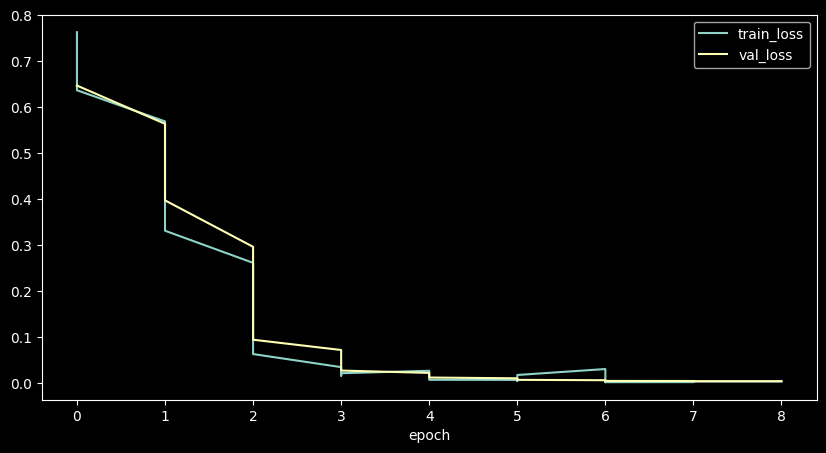

In [172]:
df = pd.read_csv('checkpoints/BA2Motifs/metrics_gnn.csv')
df.interpolate('linear').plot(x='epoch', y=['train_loss', 'val_loss'], figsize=(10, 5))

## PGExplainer

### Dataset collection

In [174]:
class ExplainerDataModule(pl.LightningDataModule):
    
    def __init__(self, dataset, name, model, alpha=30, mode='node', batch_size=1):
        super().__init__()
        self.dataset = dataset
        self.name = name
        self.model = model.eval()
        self.alpha = alpha
        self.mode = mode
        self.batch_size = batch_size
        
    def prepare_data(self):
        if self.mode == 'node':
            self.dataset_len = self.dataset.num_nodes
        else:
            self.dataset_len = len(self.dataset)
        
        self.train_idx, self.val_test_idx = train_test_split(torch.arange(self.dataset_len), shuffle=True, train_size=self.alpha)
        self.val_idx, self.test_idx = train_test_split(self.val_test_idx, shuffle=True, train_size=0.5)
        
    def setup(self, stage=None):
        graphs = []
        val_graphs = []
        self.preproc_dataset = []
        self.val_dataset = []
        val_idcs = []
        if stage == "fit":
            idcs = self.train_idx
            val_idcs = self.val_idx
        elif stage == "test":
            idcs = self.test_idx
        elif stage == "predict":
            idcs = torch.randint(0, self.dataset_len, (5,))
            
        if self.mode == "node":
            for idx in idcs:
                graph = self.dataset.clone()
                _, sub_graph_edge_index, _, edge_mask = k_hop_subgraph(int(idx), 3, self.dataset.edge_index)
                graph.edge_index = sub_graph_edge_index
                graph.edge_mask = graph.edge_mask[edge_mask]
                graphs.append((graph, idx))
            for idx in val_idcs:
                graph = self.dataset.clone()
                _, sub_graph_edge_index, _, edge_mask = k_hop_subgraph(int(idx), 3, self.dataset.edge_index)
                graph.edge_index = sub_graph_edge_index
                graph.edge_mask = graph.edge_mask[edge_mask]
                val_graphs.append((graph, idx))
        else:
            for idx in idcs:
                graph = self.dataset[idx]
                graphs.append((graph, idx))
            for idx in val_idcs:
                graph = self.dataset[idx]
                val_graphs.append((graph, idx))
                
        for g, idx in graphs:
            y_pred, z = self.model(g)
            explainer_in = self._process_embeddings(g.edge_index, idx, z)
            self.preproc_dataset.append((y_pred, explainer_in, g, idx))
        
        for g, idx in val_graphs:
            y_pred, z = self.model(g)
            explainer_in = self._process_embeddings(g.edge_index, idx, z)
            self.val_dataset.append((y_pred, explainer_in, g, idx))
            
    def _process_embeddings(self, edge_indexes, node_idx, embeddings):  
        """
            This function is readapted from the following implementation:
            https://github.com/LarsHoldijk/RE-ParameterizedExplainerForGraphNeuralNetworks/blob/main/ExplanationEvaluation/explainers/PGExplainer.py
        """
        if self.mode == "node":
            explainer_in = torch.cat([embeddings[edge_indexes[0]],
                                      embeddings[edge_indexes[1]],
                                      embeddings[node_idx].repeat(edge_indexes.shape[1], 1)], dim=1)
        else:
            explainer_in = torch.cat([embeddings[edge_indexes[0]],
                                      embeddings[edge_indexes[1]]], dim=1)
        return explainer_in
                
    def train_dataloader(self):
        return DataLoader(self.preproc_dataset, batch_size=self.batch_size, shuffle=False)
    
    def val_dataloader(self):
        return DataLoader(self.val_dataset, batch_size=self.batch_size, shuffle=False)
    
    def test_dataloader(self):
        return DataLoader(self.preproc_dataset, batch_size=self.batch_size, shuffle=False)  
    
    def predict_dataloader(self):
        return DataLoader(self.preproc_dataset, batch_size=self.batch_size, shuffle=False)  

In [175]:
node_explainer_module = ExplainerDataModule(g, "BA-Shapes", node_gnn, mode='node', batch_size=1)

In [176]:
graph_explainer_module = ExplainerDataModule(graph_dataset, "BA2Motifs", graph_gnn, mode='graph', batch_size=1)

### Model definition

In [271]:
class PGExplainer(pl.LightningModule):
    
    def __init__(self, model:pl.LightningModule, lr=3e-3, size_r=0.05, ent_r=1.0, max_epoch=30, temp=(5.0, 2.0), mode='node', *args: Any, **kwargs: Any) -> None:
        super().__init__(*args, **kwargs)
        if mode == 'node':
            self.mlp = nn.Sequential(
                nn.Linear(60, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
            )
        elif mode == 'graph':
            self.mlp = nn.Sequential(
                nn.Linear(40, 64),
                nn.ReLU(),
                nn.Linear(64, 1),
            )
        else:
            raise ValueError("mode must be either 'node' or 'graph'")
        
        self.mode = mode
        self.model = model
        self.model.freeze()
        self.lr = lr
        self.temp = temp
        self.max_epoch = max_epoch
        self.size_r = size_r
        self.ent_r = ent_r
        self.automatic_optimization = False
        self.train_loss = None
        self.val_loss = None
        self.curr_temp = None
        
    def _sample_graph(self, om, temp, training=False):
        """ This implementation is readapted from this 
            https://github.com/LarsHoldijk/RE-ParameterizedExplainerForGraphNeuralNetworks/blob/main/ExplanationEvaluation/explainers/PGExplainer.py
        """
        if training:
            eps = 1e-4
            eps = (eps - (1 - eps)) * torch.rand_like(om) + (1 - eps)
            uniform = torch.log(eps) - torch.log(1 - eps)
            uniform = (uniform + om) / temp
            edge_mask = torch.sigmoid(uniform)
        else:
            edge_mask = torch.sigmoid(om)
        return edge_mask
    
    def _loss(self, y0, ys, edge_mask):
        loss = F.cross_entropy(ys, y0.argmax(dim=-1))
        
        size_constraint = torch.sum(edge_mask) * self.size_r
        mask = 0.99 * edge_mask + 0.005
        ent_constraint = -mask * torch.log(mask) - (1 - mask) * torch.log(1 - mask)
        ent_constraint = torch.mean(ent_constraint) * self.ent_r
        
        return loss + size_constraint + ent_constraint
    
    def _node_edges(self, edge_index, node_idx):
        return edge_index[:, (edge_index[0] == node_idx) | (edge_index[1] == node_idx)]
        
        
    def forward(self, z):
        om = self.mlp(z)
        return om
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)
    
    def training_step(self, data, batch_idx):
        opt = self.optimizers()
        
        if batch_idx == 0:
            opt.zero_grad()
            self.train_loss = torch.zeros(1, dtype=torch.float, device=self.device).detach()
            self.curr_temp = self.temp[0] * (self.temp[1] / self.temp[0]) ** self.current_epoch
        y0, z, g0, idx = data
        
        idx = int(idx)
        om = self(z.detach())
        edge_mask = self._sample_graph(om, self.curr_temp, training=True).squeeze()
        ys, _ = self.model(g0, edge_mask)
        ys = ys.unsqueeze(0)
        if self.mode == 'node':
            ys = ys[:, idx].squeeze(1)
            y0 = y0[:, idx].squeeze(1)
            
        idx_loss = self._loss(y0, ys, edge_mask)
        self.train_loss += idx_loss
            
        if batch_idx == self.trainer.num_training_batches - 1:
            self.log('mean_idx_loss', self.train_loss/self.trainer.num_training_batches, prog_bar=True, batch_size=1)
            self.log('train_loss', self.train_loss, prog_bar=True, on_step=False, on_epoch=True)
            self.manual_backward(self.train_loss)
            opt.step()
            
    def validation_step(self, data, batch_idx):
        if batch_idx == 0:
            self.val_loss = torch.zeros(1, dtype=torch.float, device=self.device).detach()
            self.curr_temp = self.temp[0] * (self.temp[1] / self.temp[0]) ** self.current_epoch
            
        y0, z, g0, idx = data
        
        idx = int(idx)
        om = self(z.detach())
        edge_mask = self._sample_graph(om, self.curr_temp, training=True).squeeze()
        ys, _ = self.model(g0, edge_mask)
        ys = ys.unsqueeze(0)
        if self.mode == 'node':
            ys = ys[:, idx].squeeze(1)
            y0 = y0[:, idx].squeeze(1)
            
        idx_loss = self._loss(y0, ys, edge_mask)
        self.val_loss += idx_loss
            
        if batch_idx == self.trainer.num_val_batches[0] - 1:
            self.log('mean_idx_val_loss', self.val_loss/self.trainer.num_val_batches[0], prog_bar=True, batch_size=1)
            self.log('val_loss', self.val_loss, prog_bar=True, on_step=False, on_epoch=True)
            
    def test_step(self, batch, _):
        self.explain(batch)
        
    def explain(self, data):
        y0, z, g0, idx = data
        
        idx = int(idx)
        om = self(z.detach())
        edge_mask = self._sample_graph(om, self.curr_temp, training=False).squeeze()
        ys, _ = self.model(g0, edge_mask)
        ys = ys.unsqueeze(0)
        if self.mode == 'node':
            ys = ys[:, idx].squeeze(1)
            y0 = y0[:, idx].squeeze(1)
            
        idx_loss = self._loss(y0, ys, edge_mask)
        self.log('test_loss', idx_loss, prog_bar=True, batch_size=1)
        
        if g0.y.shape[0] == 1 and g0.y == 0:
            gt_edge_mask = torch.zeros_like(edge_mask)
        else:
            gt_edge_mask = g0.edge_mask
        try:
            self.log('roc_auc_score', roc_auc_score(gt_edge_mask.detach().cpu(), edge_mask.detach().cpu()), prog_bar=True, batch_size=1)
        except ValueError:
            pass
        

### Node Explainer

In [272]:
node_explainer = PGExplainer(model=node_gnn, mode='node')

In [273]:
es_callback = pl.callbacks.EarlyStopping('val_loss', patience=10, mode='min')
trainer = pl.Trainer(max_epochs=30, callbacks=[es_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [274]:
if os.path.isfile("checkpoints/BA-Shapes/node_explainer.ckpt"):
    trainer.fit(node_explainer, datamodule=node_explainer_module, ckpt_path="checkpoints/BA-Shapes/node_explainer.ckpt")
else:
    trainer.fit(node_explainer, datamodule=node_explainer_module)

Restoring states from the checkpoint path at checkpoints/BA-Shapes/node_explainer.ckpt
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from '/home/ninjak/Documenti/uni/neural_networks/lightning_logs/version_64/checkpoints' to '/home/ninjak/Documenti/uni/neural_networks/lightning_logs/version_94/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | mlp   | Sequential | 4.0 K 
1 | model | NodeGNN    | 964   
-------------------------------------
4.0 K     Trainable params
964       Non-trainable params
4.9 K     Total params
0.020     Total estimated model params size (MB)
Restored all states from the checkpoint at checkp

/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of trainin

In [275]:
trainer.test(node_explainer, node_explainer_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 335/335 [00:03<00:00, 103.57it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       roc_auc_score       │     0.837651649033262     │
│         test_loss         │     5.043288230895996     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 5.043288230895996, 'roc_auc_score': 0.837651649033262}]

<Axes: xlabel='epoch'>

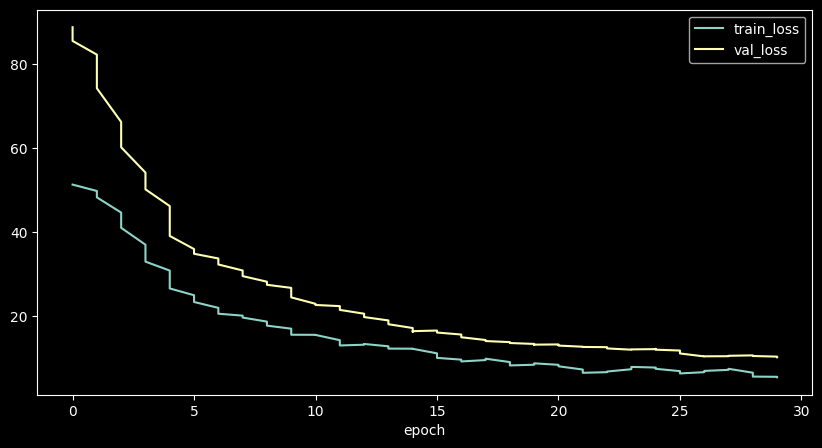

In [282]:
df = pd.read_csv('checkpoints/BA-Shapes/metrics_explainer.csv')
df.interpolate('linear').plot(x='epoch', y=['train_loss', 'val_loss'], figsize=(10, 5))

### Graph Explainer

In [276]:
graph_explainer = PGExplainer(graph_gnn, mode='graph')

In [277]:
es_callback = pl.callbacks.EarlyStopping('val_loss', patience=10, mode='min')
trainer = pl.Trainer(max_epochs=30, callbacks=[es_callback])

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [278]:
if os.path.isfile("checkpoints/BA2Motifs/graph_explainer.ckpt"):
    trainer.fit(graph_explainer, datamodule=graph_explainer_module, ckpt_path="checkpoints/BA2Motifs/graph_explainer.ckpt")
else:
    trainer.fit(graph_explainer, datamodule=graph_explainer_module)

Restoring states from the checkpoint path at checkpoints/BA2Motifs/graph_explainer.ckpt
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:337: UserWarning: The dirpath has changed from '/home/ninjak/Documenti/uni/neural_networks/lightning_logs/version_76/checkpoints' to '/home/ninjak/Documenti/uni/neural_networks/lightning_logs/version_95/checkpoints', therefore `best_model_score`, `kth_best_model_path`, `kth_value`, `last_model_path` and `best_k_models` won't be reloaded. Only `best_model_path` will be reloaded.
  warnings.warn(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | mlp   | Sequential | 2.7 K 
1 | model | GraphGNN   | 1.3 K 
-------------------------------------
2.7 K     Trainable params
1.3 K     Non-trainable params
4.0 K     Total params
0.016     Total estimated model params size (MB)
Restored all states from the checkpoint at check

/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/loops/fit_loop.py:280: PossibleUserWarning: The number of trainin

In [283]:
trainer.test(graph_explainer, graph_explainer_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/ninjak/miniconda3/envs/neural-networks/lib/python3.8/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:430: PossibleUserWarning: The dataloader, test_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 12 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Testing DataLoader 0: 100%|██████████| 485/485 [00:03<00:00, 124.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       roc_auc_score       │   0.0044976437065044695   │
│         test_loss         │    0.7898530960083008     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.7898530960083008, 'roc_auc_score': 0.0044976437065044695}]

<Axes: xlabel='epoch'>

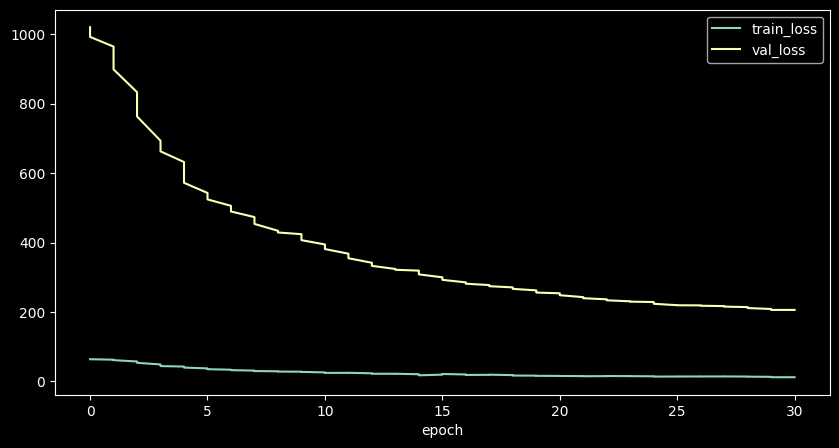

In [281]:
df = pd.read_csv('checkpoints/BA2Motifs/metrics_explainer.csv')
df.interpolate('linear').plot(x='epoch', y=['train_loss', 'val_loss'], figsize=(10, 5))